# Assignment 3

In [2]:
import nltk
import pandas as pd
import numpy as np
import itertools
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import reuters
from nltk.corpus import stopwords

from gensim.models.wrappers import FastText

# If 'punkt' is missing then comment out the below line
# nltk.download('punkt')
# If 'stopwords' is missing then comment out the below line
# nltk.download('stopwords')

# Globals
Nclasses = 4


## Resuseable Code 

### Evaluation Metrics

In [3]:
def recall(y_true, y_pred):
    
    """
    Recall metric.
    Only computes a batch-wise average of recall.
    Computes the recall, a metric for multi-label classification of
    how many relevant items are selected.
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def precision(y_true, y_pred):
    
    """
    Precision metric.
    Only computes a batch-wise average of precision.
    Computes the precision, a metric for multi-label classification of
    how many selected items are relevant.
    Source
    ------
    https://github.com/fchollet/keras/issues/5400#issuecomment-314747992
    """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def f1(y_true, y_pred):
    
    """Calculate the F1 score."""
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r))


def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)), axis=1)

### Data Formatting Methods

In [4]:
#Calculate centroid function

def text_centroid(text, model):
    
    text_vec =[]
    counter = 0
    sent_text = nltk.sent_tokenize(text)
    for sentence in sent_text:
        sent_tokenized = nltk.word_tokenize(sentence)
        for word in sent_tokenized:
            try:
                if counter == 0:
                    text_vec = model[word.lower()]
                else:
                    text_vec = np.add(text_vec, model[word.lower()])
                counter+=1
            except:
                pass
    
    return np.asarray(text_vec) / counter


### Visualization Methods

In [5]:
# summarize history for f1
def plot_history(history_obj):
    plt.plot(history_obj.history['f1'])
    plt.plot(history_obj.history['val_f1'])
    plt.title('model f1')
    plt.ylabel('f1-score')
    plt.xlabel('epoch')
    plt.legend(['train', 'dev'], loc='upper left')
    plt.show()
    
    # summarize history for loss
    plt.plot(history_obj.history['loss'])
    plt.plot(history_obj.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'dev'], loc='upper right')
    plt.show()

# Load and Process Dataset

In [6]:
# dataset can be found at 
# https://d1p17r2m4rzlbo.cloudfront.net/wp-content/uploads/2016/03/judge-1377884607_tweet_product_company.csv
total_df = pd.read_csv('stack-overflow-data.csv')
data = total_df.loc[total_df['tags'].isin(['python', 'java', 'c', 'javascript'])]
# data = data[data.post.notnull()]

data.head(20)
data.shape
data['tags'].value_counts()

c             2000
java          2000
javascript    2000
python        2000
Name: tags, dtype: int64

In [7]:
def load_data(input_data, label_field, text_field, input_ins='as_tf_idf', **kwargs):
    """
    Generates the train-test data for the model based on the given argunments.
    
    Args:
        'input_data' (pandas.DataFrame): The dataset Dataframe that will be splitted in train-test data. 
        'input_ins' (str): If 'as_tf_idf' is given then it generates tf-idf vectors per text row
                     If 'as_centroids' is given then it generates centroids per text row
    It returns a dictionary with the below structure:
        {
            'x_train' (numpy.array),
            'x_test' (numpy.array),
            'y_train' (numpy.array),
            'y_test' (numpy.array),
        }
    
    """
    assert all([label_field, text_field]),\
        "Fields <label_field>, <text_field> cannot be None or empty"
    train, test = train_test_split(input_data, test_size = 0.3, random_state=1596)
    
    x_train = np.array(list(itertools.chain.from_iterable(train[[text_field]].values.astype('U').tolist())))
    x_test = np.array(list(itertools.chain.from_iterable(test[[text_field]].values.astype('U').tolist())))
    
    if input_ins == 'as_tf_idf':
        stop_words = stopwords.words("english")
        vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features = 5000,sublinear_tf=True,stop_words=stopwords.words('english'))
        
        x_train = vectorizer.fit_transform(x_train).toarray()
        x_test = vectorizer.transform(x_test).toarray()
        
    else:
        x_train = np.array(list(map(lambda text: text_centroid(text, fasttext), x_train)))
        x_train = np.stack(x_train, axis=0)
        x_test = np.array(list(map(lambda text: text_centroid(text, fasttext), x_test)))
        x_test = np.stack(x_test, axis=0)
        
    mlb = MultiLabelBinarizer()

    y_train = mlb.fit_transform(train[[label_field]].values.tolist())
    y_test = mlb.transform(test[[label_field]].values.tolist())
    
    return {
        'x_train': x_train,
        'x_test': x_test,
        'y_train': y_train,
        'y_test': y_test
    }


# Text classification with tf*idf features

## MLP classifier in Keras using tf*idf features

In [7]:
import warnings
import sklearn.exceptions
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
from keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.optimizers import Adam
from keras import backend as K


model_data = load_data(data, 'tags', 'post')
print(model_data['y_train'].shape)
model = Sequential()
model.add(Dense(512, input_dim=model_data['x_train'].shape[1] , activation='relu'))
# Dropout probability in order to avoid overfitting.
model.add(Dropout(0.5))
model.add(Dense(256,  activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(Nclasses,  activation='sigmoid'))

print(model.summary())
#Model compilation parameterized with  
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=0.001),
              metrics=[precision, recall, f1, accuracy])

checkpoint = ModelCheckpoint('keras_tf_idf_model', monitor='val_f1', verbose=1, save_best_only=True, mode='max')

history = model.fit(model_data['x_train'], model_data['y_train'],
              batch_size=32,
              epochs=10,
              verbose = 0,
              callbacks=[checkpoint,TQDMNotebookCallback()],
              validation_data=(model_data['x_test'], model_data['y_test']),
              shuffle=True)

Using TensorFlow backend.


(5600, 4)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               2560512   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 1028      
Total params: 2,692,868
Trainable params: 2,692,868
Non-trainable params: 0
_


Epoch 00001: val_f1 improved from -inf to 0.95518, saving model to keras_tf_idf_model



Epoch 00002: val_f1 did not improve from 0.95518



Epoch 00003: val_f1 improved from 0.95518 to 0.95621, saving model to keras_tf_idf_model



Epoch 00004: val_f1 did not improve from 0.95621



Epoch 00005: val_f1 did not improve from 0.95621



Epoch 00006: val_f1 did not improve from 0.95621



Epoch 00007: val_f1 did not improve from 0.95621



Epoch 00008: val_f1 did not improve from 0.95621



Epoch 00009: val_f1 did not improve from 0.95621



Epoch 00010: val_f1 did not improve from 0.95621



 ### Notes of TF-IDF MLD Text Classification
 
 Based on the parameter tuning of the Model that is used for the text classification we hav

## Visualize Model Training History

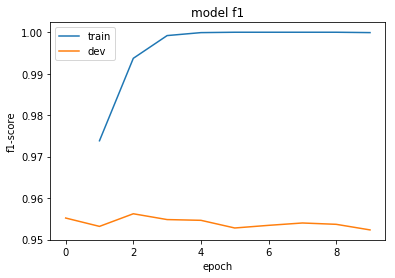

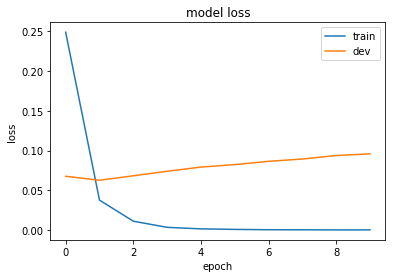

In [8]:
plot_history(history)

## Evaluate performance of tf-idf MLP model

In [9]:
score = model.evaluate(model_data['x_test'], model_data['y_test'], batch_size=32, verbose=1)

print('\nTest Binary_cross_entropy: %.4f' %  (score[0]))
print('\nTest precision: %.4f' %  (score[1]))
print('\nTest recall: %.4f' %  (score[2]))
print('\nTest f1: %.4f' % (score[3]))
print('\nTest accuracy: %.4f'% (score[4]))

2400/2400 [==============================] - 0s 139us/step

Test Binary_cross_entropy: 0.0959

Test precision: 0.9696

Test recall: 0.9363

Test f1: 0.9523

Test accuracy: 0.9767


# Text classification with embedding centroids

## MLP text classifier in Keras with fasttext centroids

In [8]:
# If 'cc.en.300.bin.gz' is not downloaded then comment out the below lines
# !wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
# !gzip -d cc.en.300.bin.gz
fasttext = FastText.load_fasttext_format('cc.en.300.bin')
model2_data = load_data(data, 'tags', 'post', 'as_centroids')

model2 = Sequential()
model2.add(Dense(256, input_dim=model2_data['x_train'].shape[1] , activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(128,  activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(64,  activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(Nclasses,  activation='sigmoid'))

print(model2.summary())
model2.compile(loss='binary_crossentropy',
               optimizer=Adam(lr=0.001),
               metrics=[precision, recall, f1, accuracy])

checkpoint2 = ModelCheckpoint('keras_fastetxt_centroids_model', monitor='val_f1', verbose=1, save_best_only=True, mode='max')

history2 = model2.fit(model2_data['x_train'], model2_data['y_train'],
              batch_size=32,
              epochs=35,
              verbose = 0,
              callbacks=[checkpoint2,TQDMNotebookCallback()],
              validation_data=(model2_data['x_test'], model2_data['y_test']),
              shuffle=True)

NameError: name 'Sequential' is not defined

 ## Visualize Model Training History

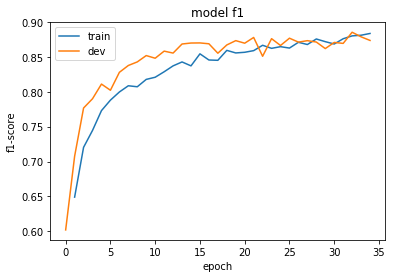

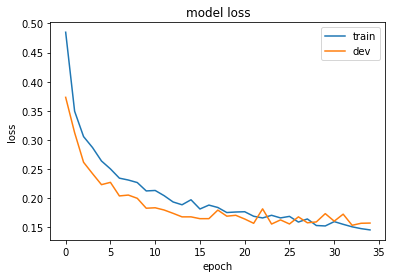

In [13]:
plot_history(history2)

## Evaluate performance of centroids MLP model

In [12]:
score2 = model2.evaluate(model2_data['x_test'], model2_data['y_test'], batch_size=32, verbose=1)
print('\nTest Binary_cross_entropy: %.4f' %  (score2[0]))
print('\nTest precision: %.4f' %  (score2[1]))
print('\nTest recall: %.4f' %  (score2[2]))
print('\nTest f1: %.4f' % (score2[3]))
print('\nTest accuracy: %.4f'% (score2[4]))

2400/2400 [==============================] - 0s 129us/step

Test Binary_cross_entropy: 0.1574

Test precision: 0.8933

Test recall: 0.8554

Test f1: 0.8736

Test accuracy: 0.9384
